# `injection`
Simulate volume controlled injection of non-wetting fluid into an image using either "image-based invasion percolation" (ibip) [^1] or "queue-based invasion percolation" (qbip) [^2].  The `injection` function is a wrapper function which provides access to both methods.  Each of the available arguments will be explained below.


[^1]: Gostick JT, Misaghian N, Yang J, Boek ES. *Simulating volume-controlled
    invasion of a non-wetting fluid in volumetric images using basic image
    processing tools*. [Computers and the Geosciences](https://doi.org/10.1016/j.cageo.2021.104978). 
    158(1), 104978 (2022)
[^2]: Gostick JT, Misaghian N, Irannezhad A, Zhao R. *A computationally
    efficient queue-based algorithm for simulating volume-controlled drainage
    under the influence of gravity on volumetric images*. [Advances in Water
    Resources](https://doi.org/10.1016/j.advwatres.2024.104799). 193(11), 104799 (2024)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import porespy as ps

ps.visualization.set_mpl_style()

## `im`
Can be a 2D or 3D image. To use the `injection` functions properly a capillary transform should be computed and provided to `pc` argument. If `pc` is not given, however, the function will still work as `pc` is computed assuming $pc = 2/dt$.  

In [2]:
im = ps.generators.blobs(shape=[200, 200], porosity=0.7, blobiness=0.75, seed=0)
inv = ps.simulations.injection(im=im)

The function returns a ``Results`` object with a images containing the invasion sequence map , the saturation map, and capillary pressure map.  These are shown below:

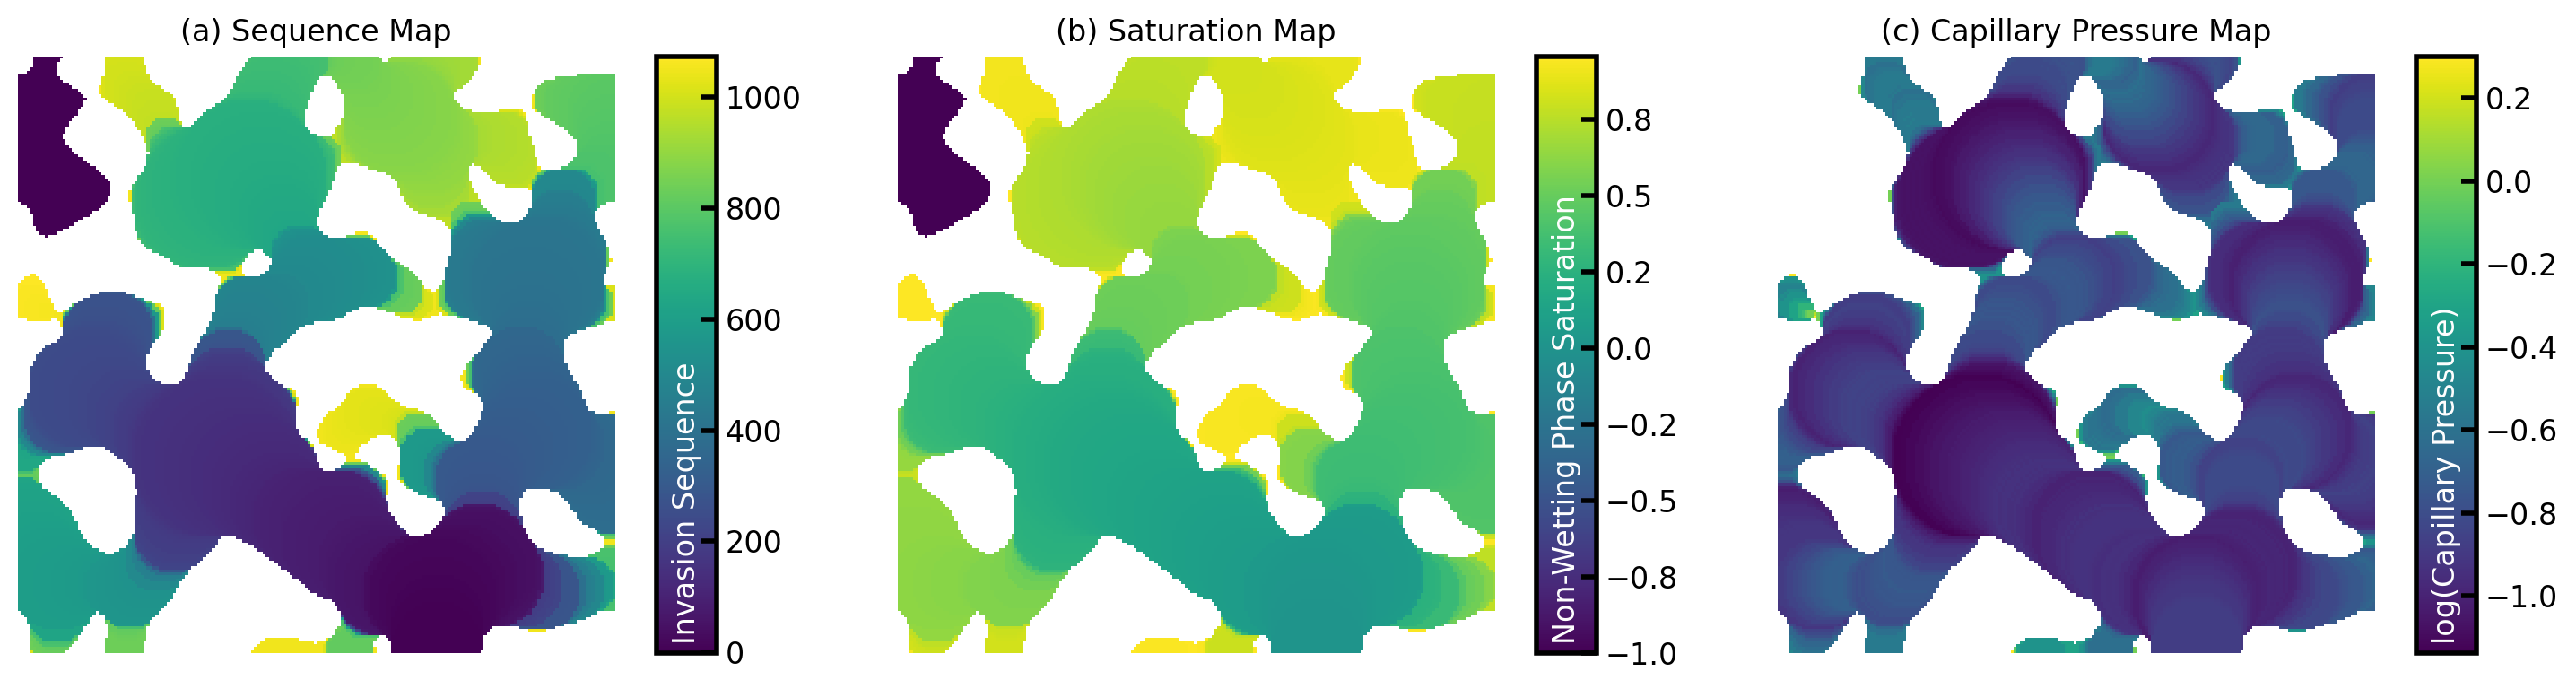

In [3]:
def plot_results(inv):
    fig, ax = plt.subplots(1, 3, figsize=[15, 4])

    h = ax[0].imshow(inv.im_seq/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.0f}")
    cbar.ax.set_title('Invasion Sequence', rotation=90, y=0, c='w')
    ax[0].axis(False)
    ax[0].set_title('(a) Sequence Map')

    h = ax[1].imshow(inv.im_snwp/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.1f}")
    cbar.ax.set_title('Non-Wetting Phase Saturation', rotation=90, y=0, c='w')
    ax[1].axis(False)
    ax[1].set_title('(b) Saturation Map')

    h = ax[2].imshow(np.log10(inv.im_pc)/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.1f}")
    cbar.ax.set_title('log(Capillary Pressure)', rotation=90, y=0, c='w')
    ax[2].axis(False)
    ax[2].set_title('(c) Capillary Pressure Map')

plot_results(inv)

## `inlets`
By default invasion begins from `x=0`, but the ``inlets`` can be specified, for instance to inject from `y=0`:

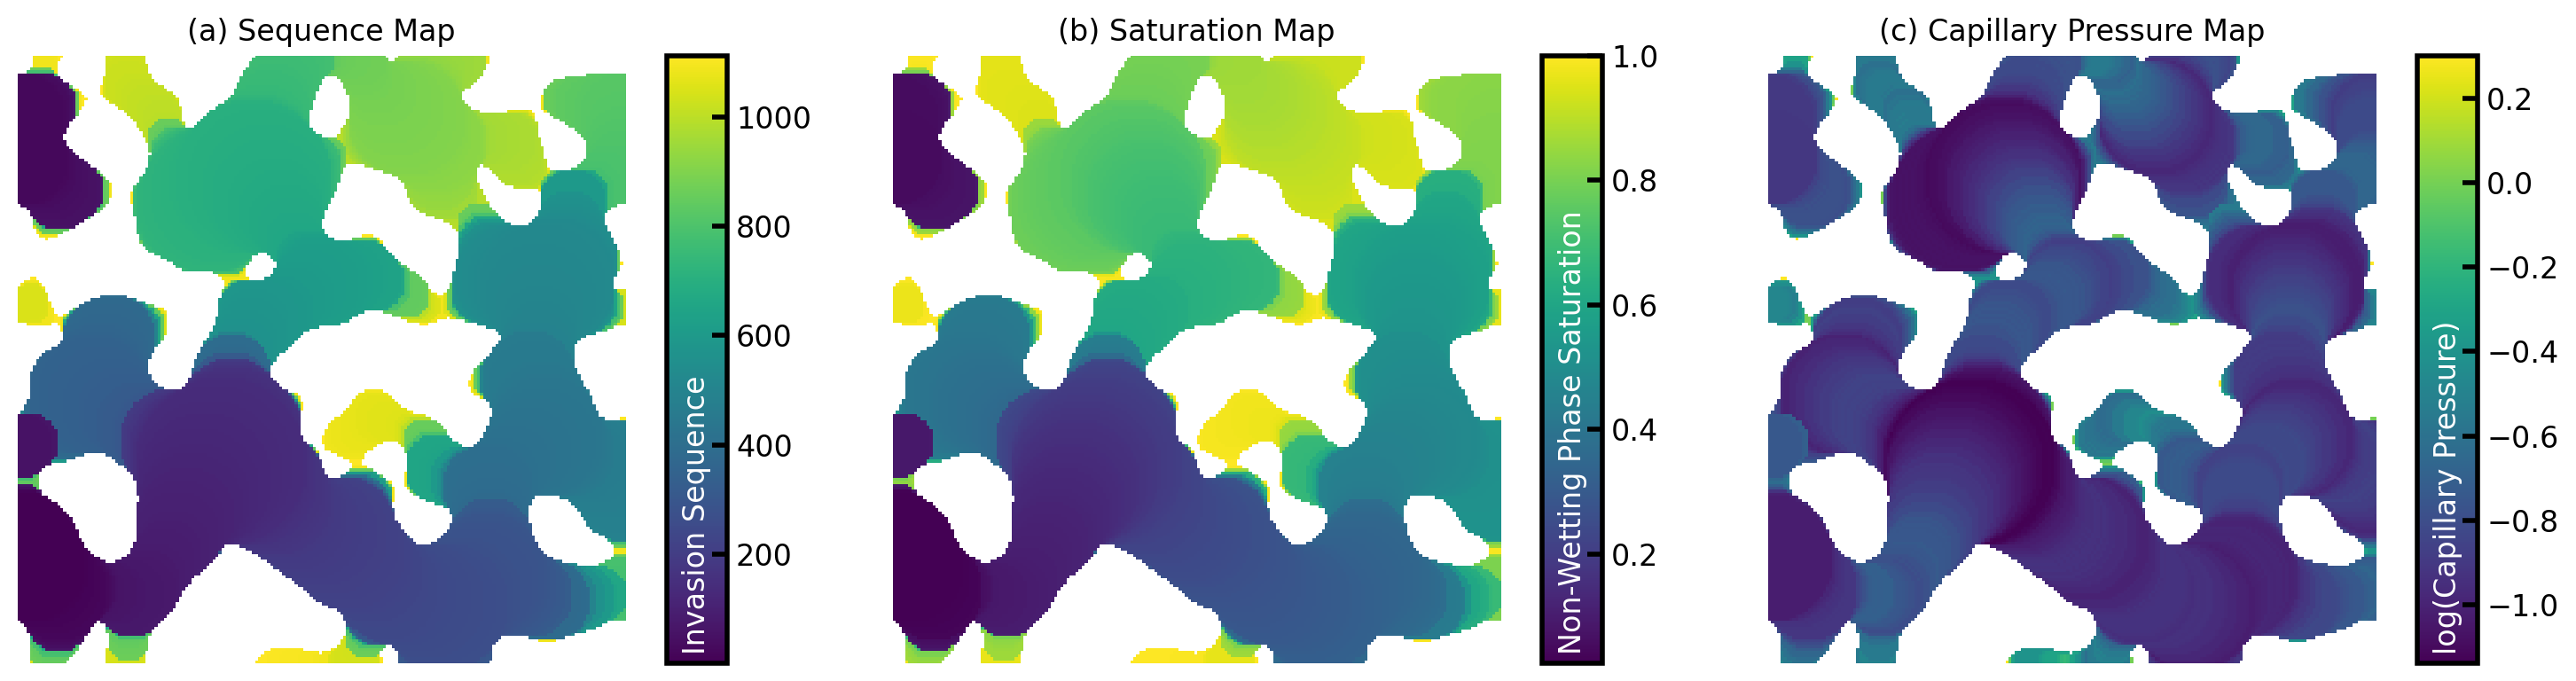

In [4]:
inlets = ps.generators.faces(im.shape, inlet=1)
inv = ps.simulations.injection(
    im=im,
    inlets=inlets,
)

plot_results(inv)

## `pc`

Supplying a capillary pressure transform as `pc` is how you tell `injection` what the capillary entry pressure of each voxel is. This is calculated separately (e.g. using `porespy.filters.capillary_transform`) so that you have maximum control over how this is calculated, for instance to include gravity.

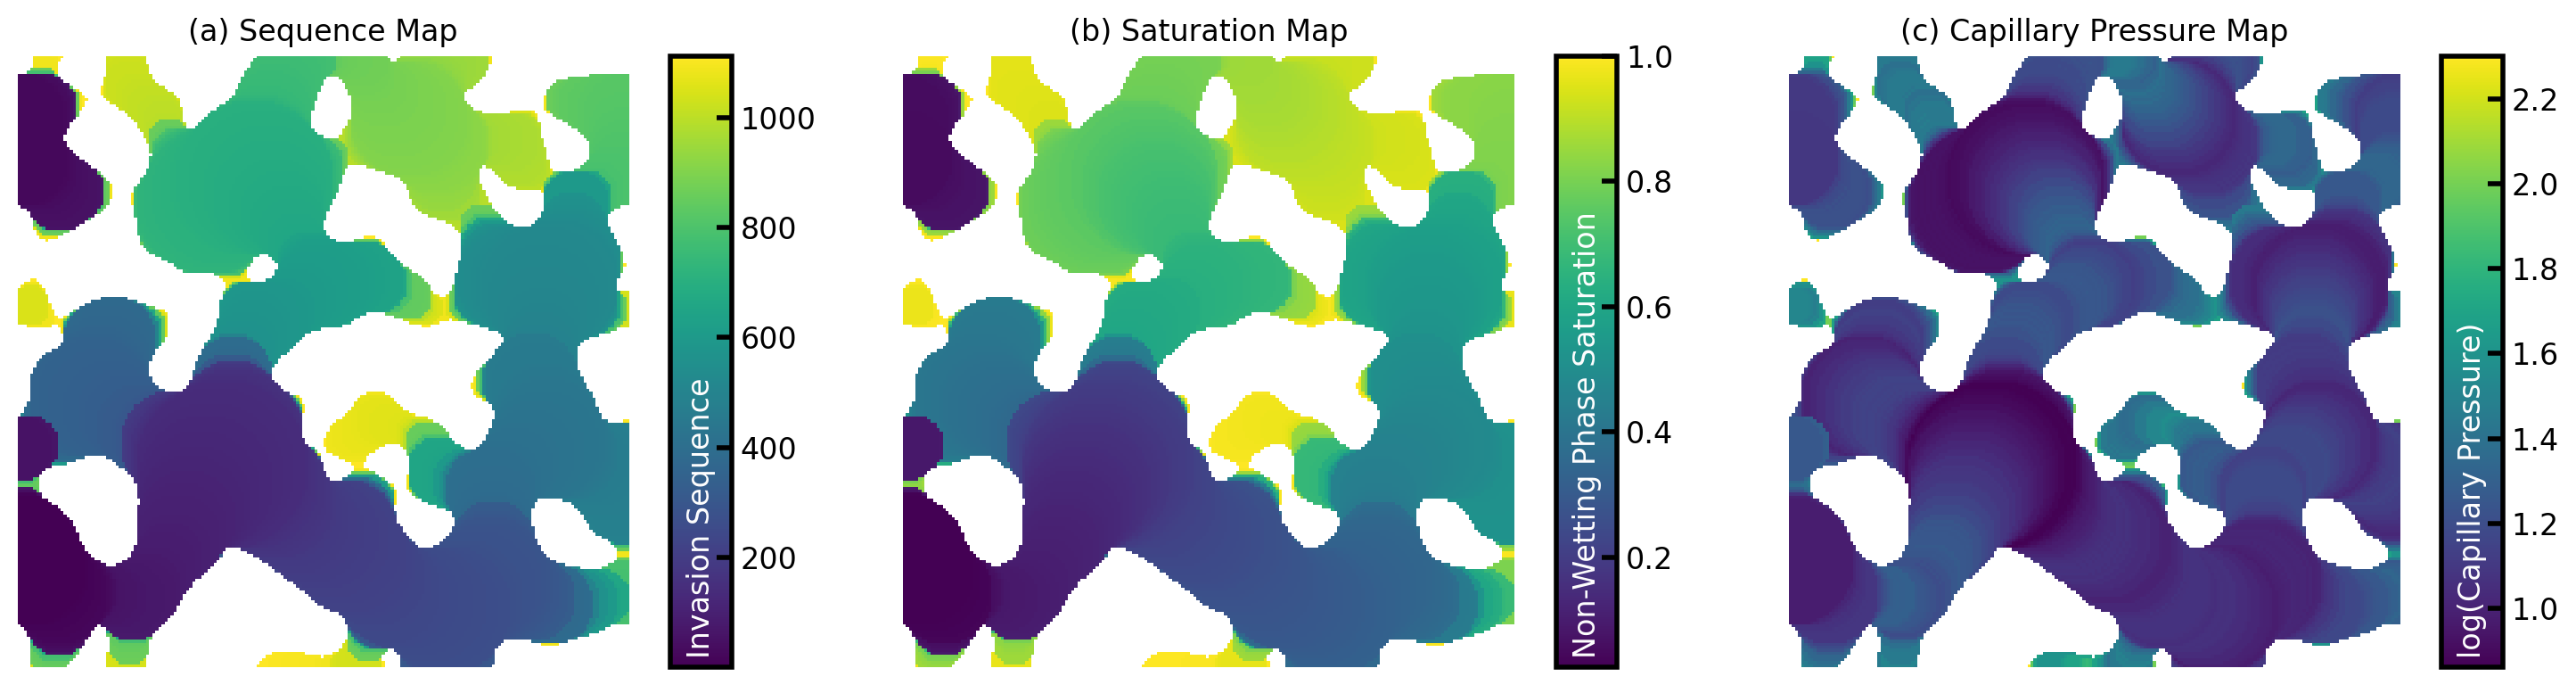

In [5]:
pc = ps.filters.capillary_transform(
    im=im,
    sigma=0.01,
    theta=180,
    g=0,
    rho_nwp=0,
    rho_wp=0,
    voxel_size=1e-4,
    )

inv = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
)

plot_results(inv)

## `outlets`

Of `outlets` are specified then trapping of the wetting phase is included in the returned displacement maps.

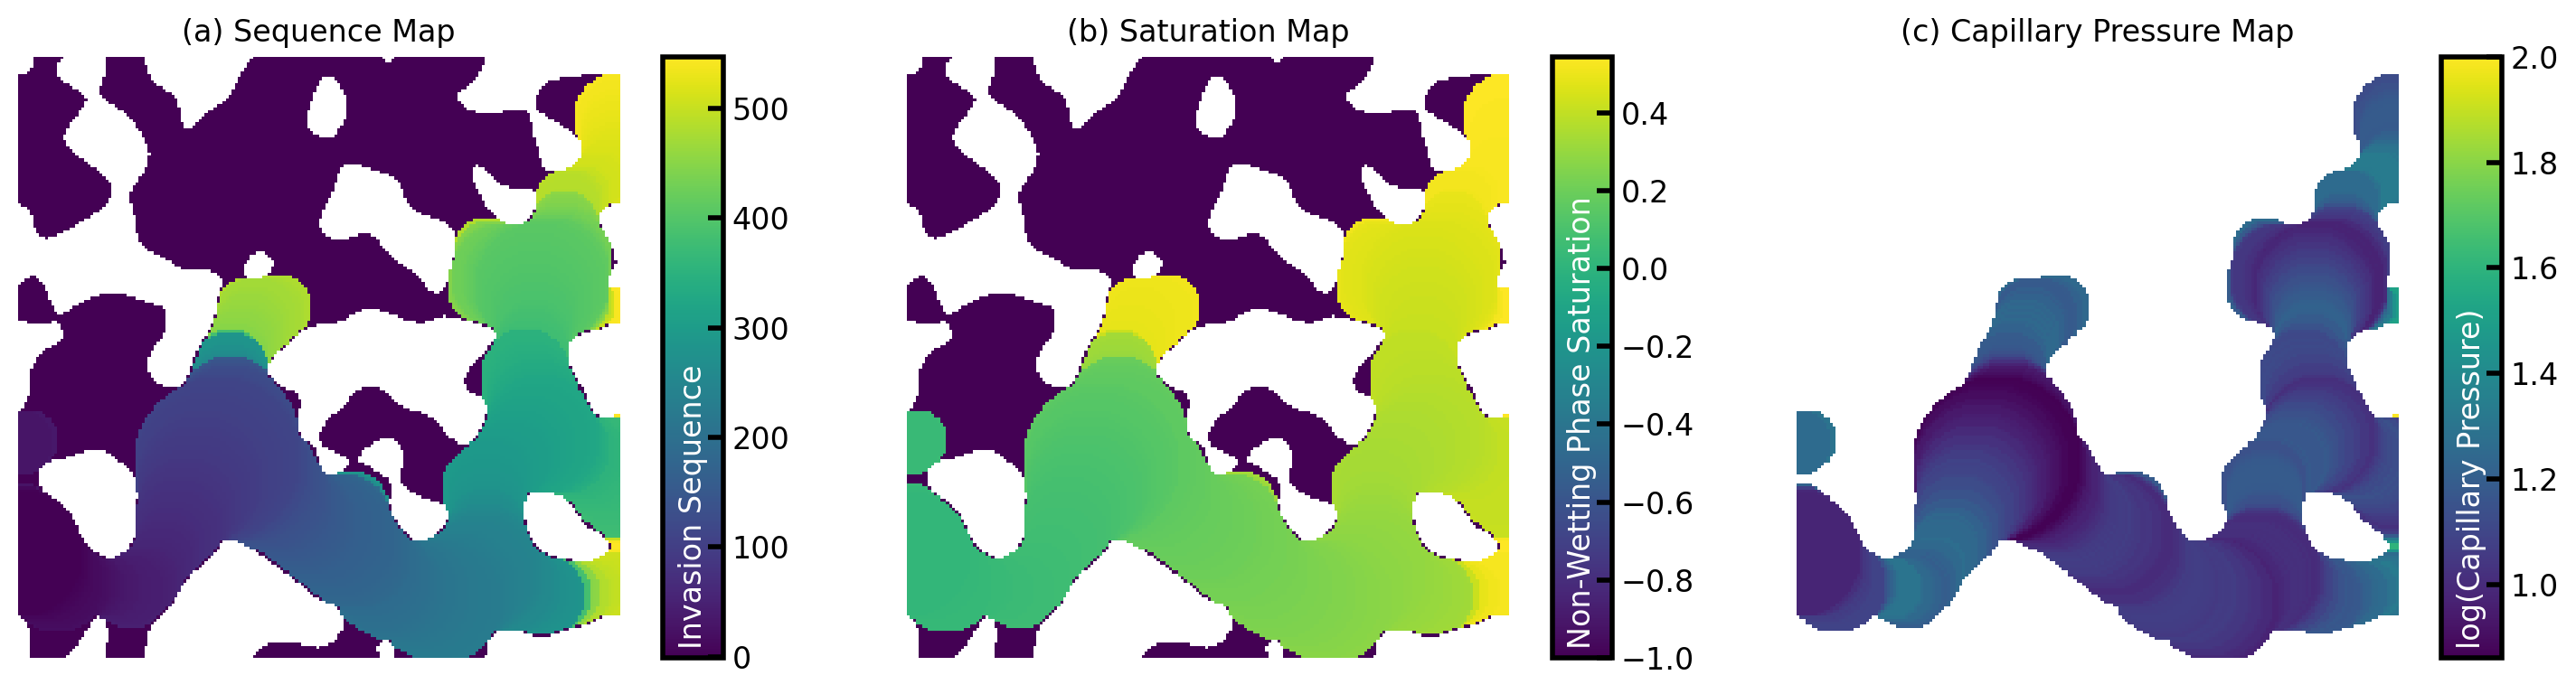

In [6]:
outlets = ps.generators.faces(im.shape, outlet=1)

inv = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
)

plot_results(inv)

## `min_size`

The `min_size` argument is passed to the `find_trapped_regions` function.  It limits the minimum size of a cluster that can be considered trapped. For instance, in the above image there can be seen many small isolated trapped pixels next to the walls.  These occur because of the digitized nature of the images, and are probably not realistic.  Supplying `min_size > 0` removes these pixels:

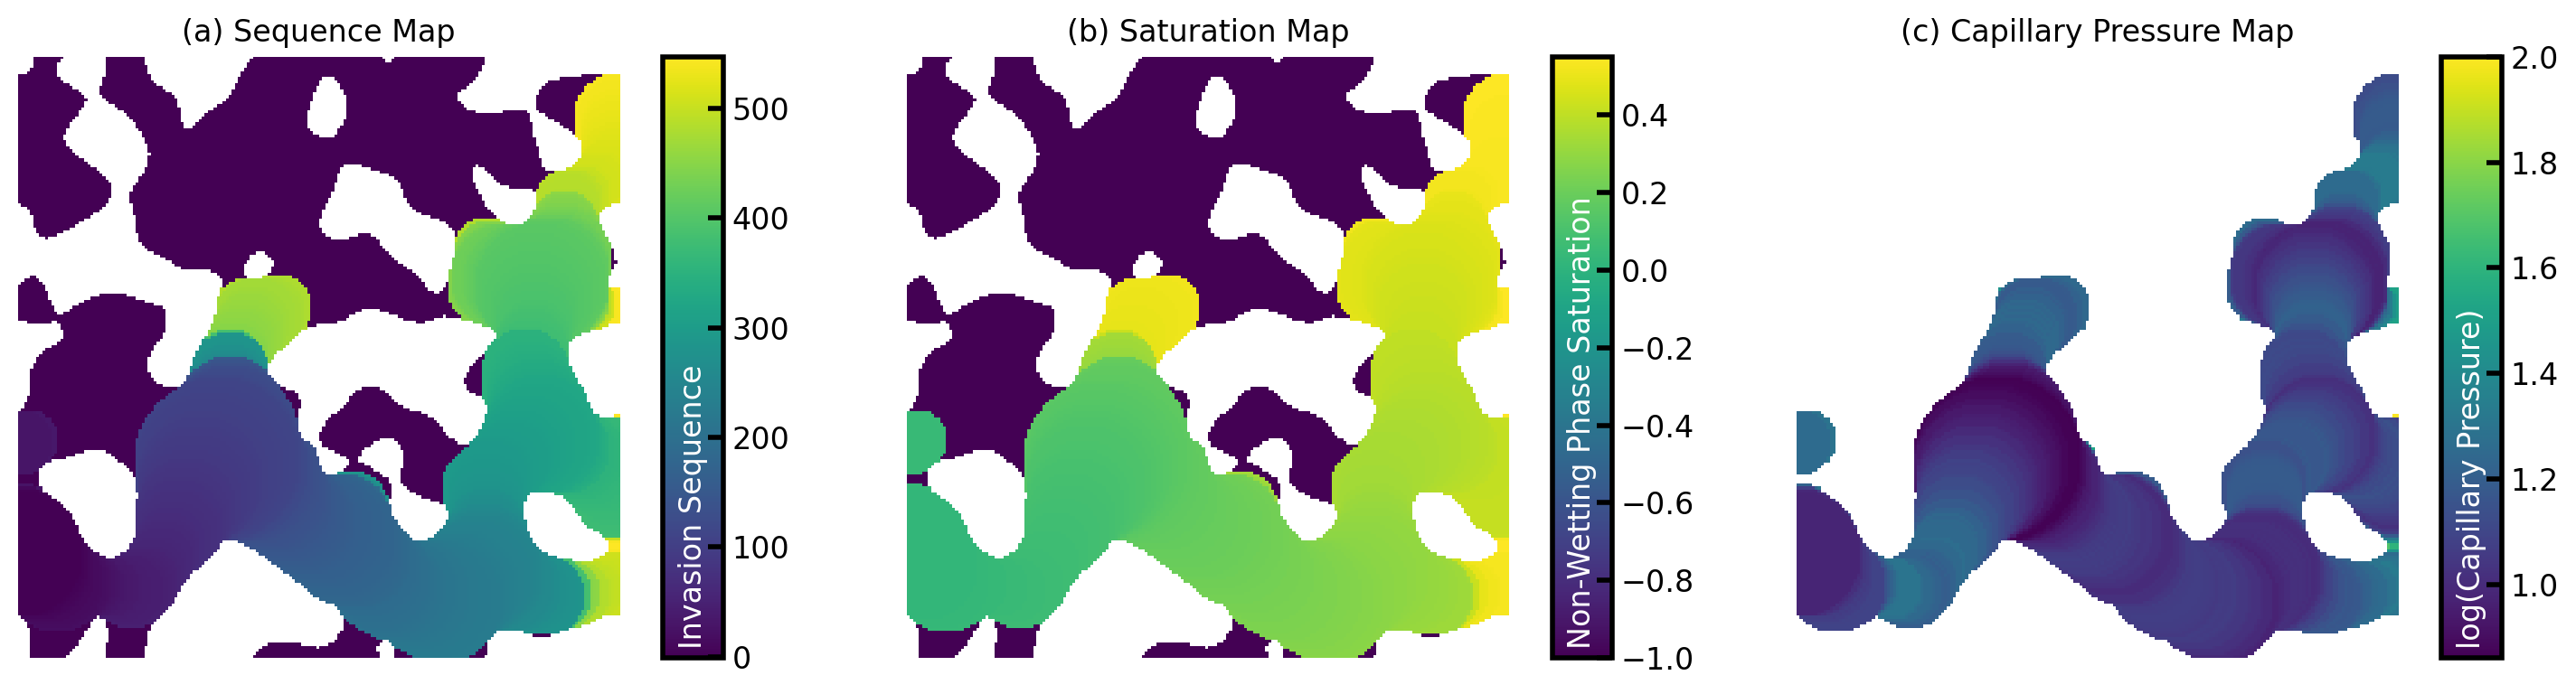

In [7]:
inv = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    min_size=5,
)

plot_results(inv)

## `conn`

The `conn` argument controls the neighbor searches for both the invasion simulation and the trapped wetting phase search (if `outlets` are provided.  It can be either `'min'` or `'max'`.  `'min'` means 4 neighbors in 2D and 6 in 3D, while `'max'` means 8 neighbors in 2D and 26 neighbors in 3D.  

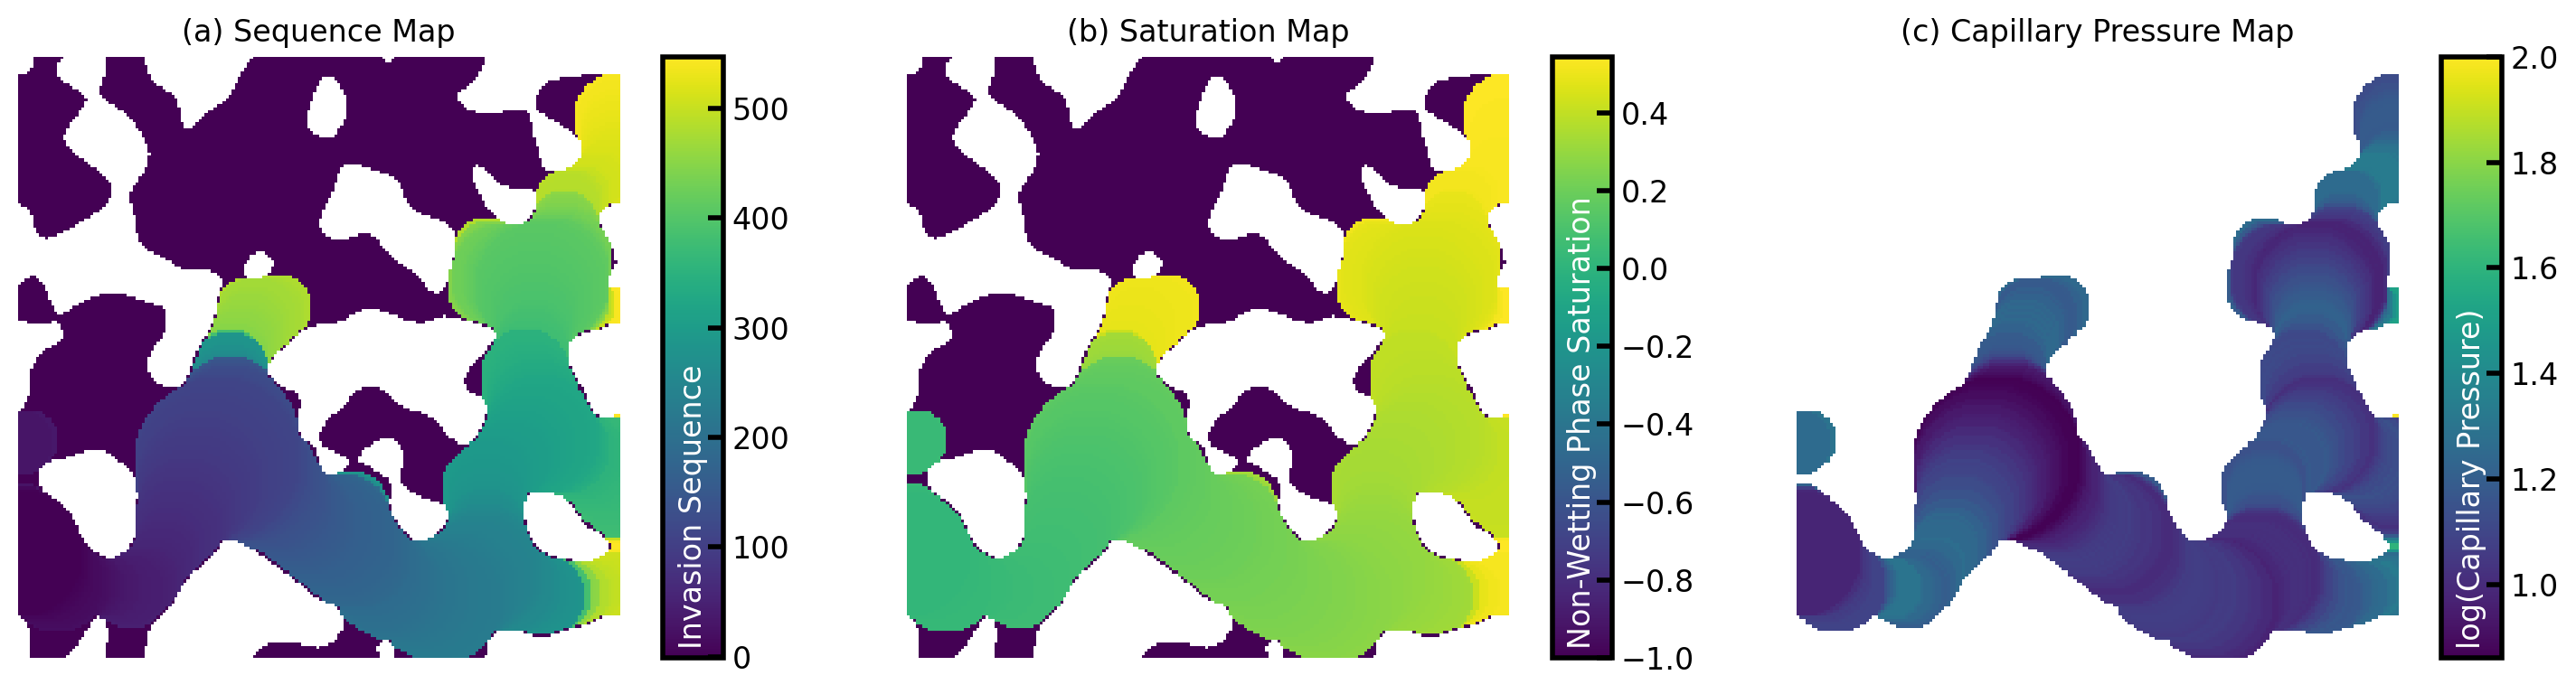

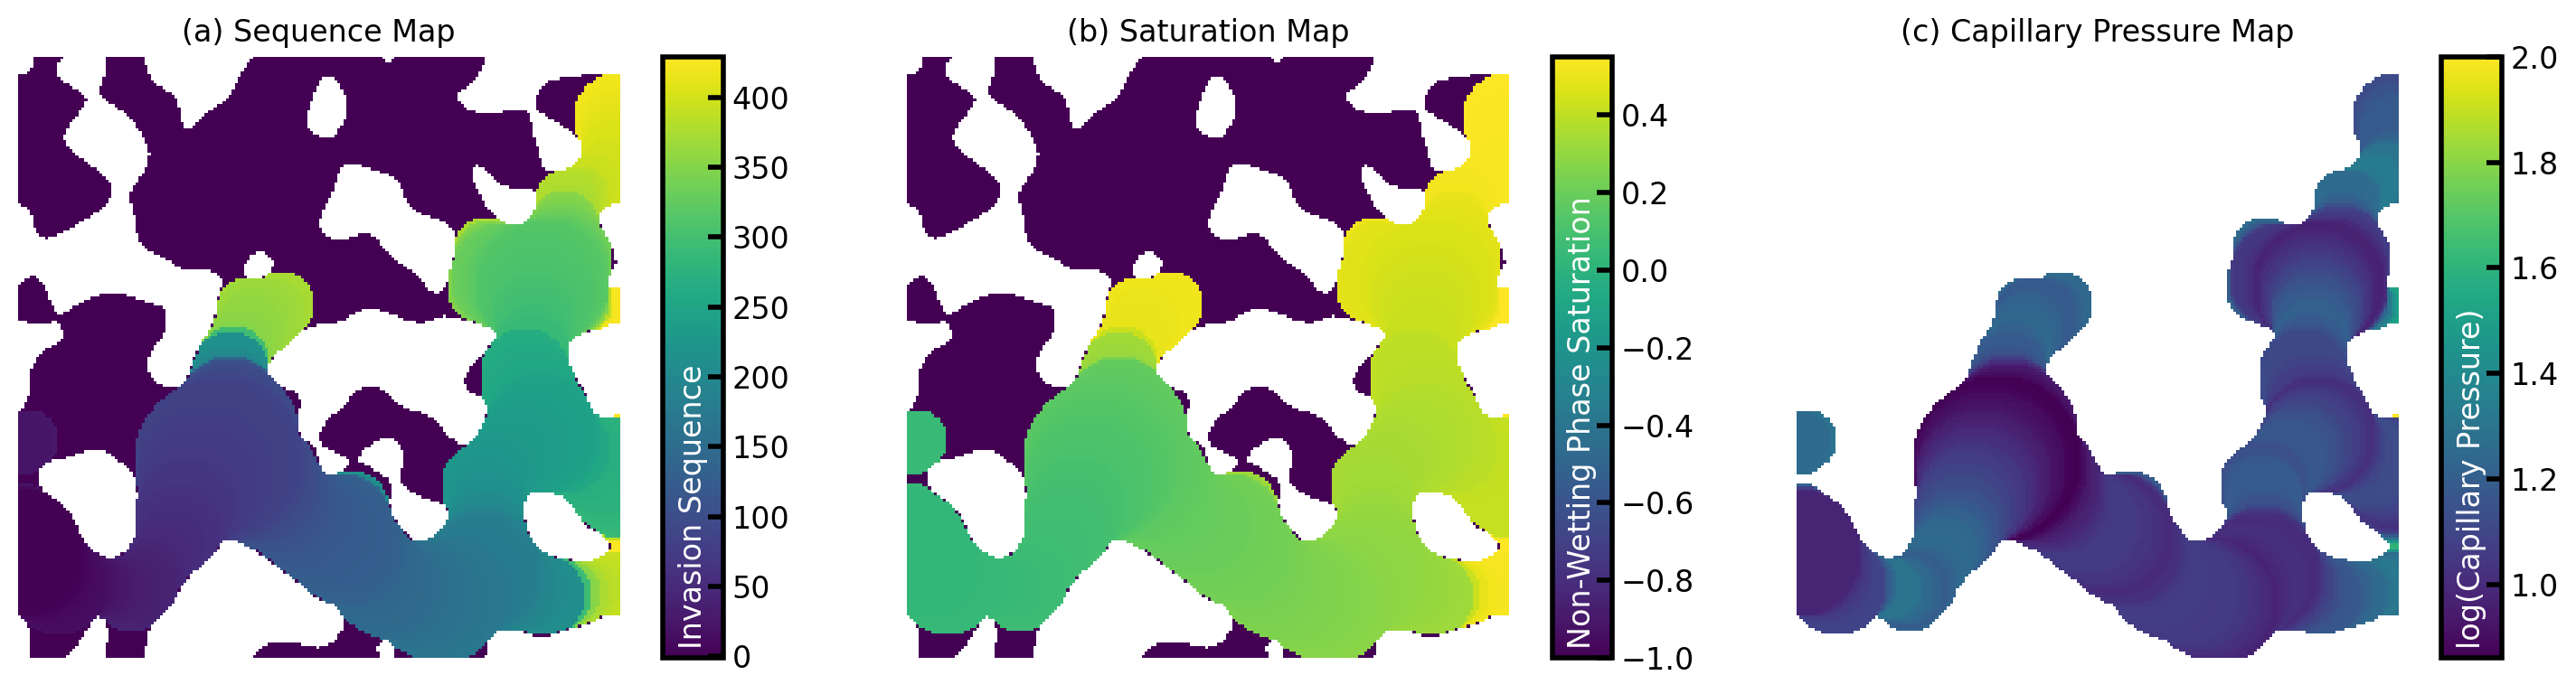

In [8]:
inv1 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    conn='min',
)
inv2 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    conn='max',
)

plot_results(inv1)
plot_results(inv2)

## `maxiter`
The maximum number of iterations to run before stopping, mostly to prevent the algorithm from stalling (or appearing to stall) on huge images. By default it will run until completion.

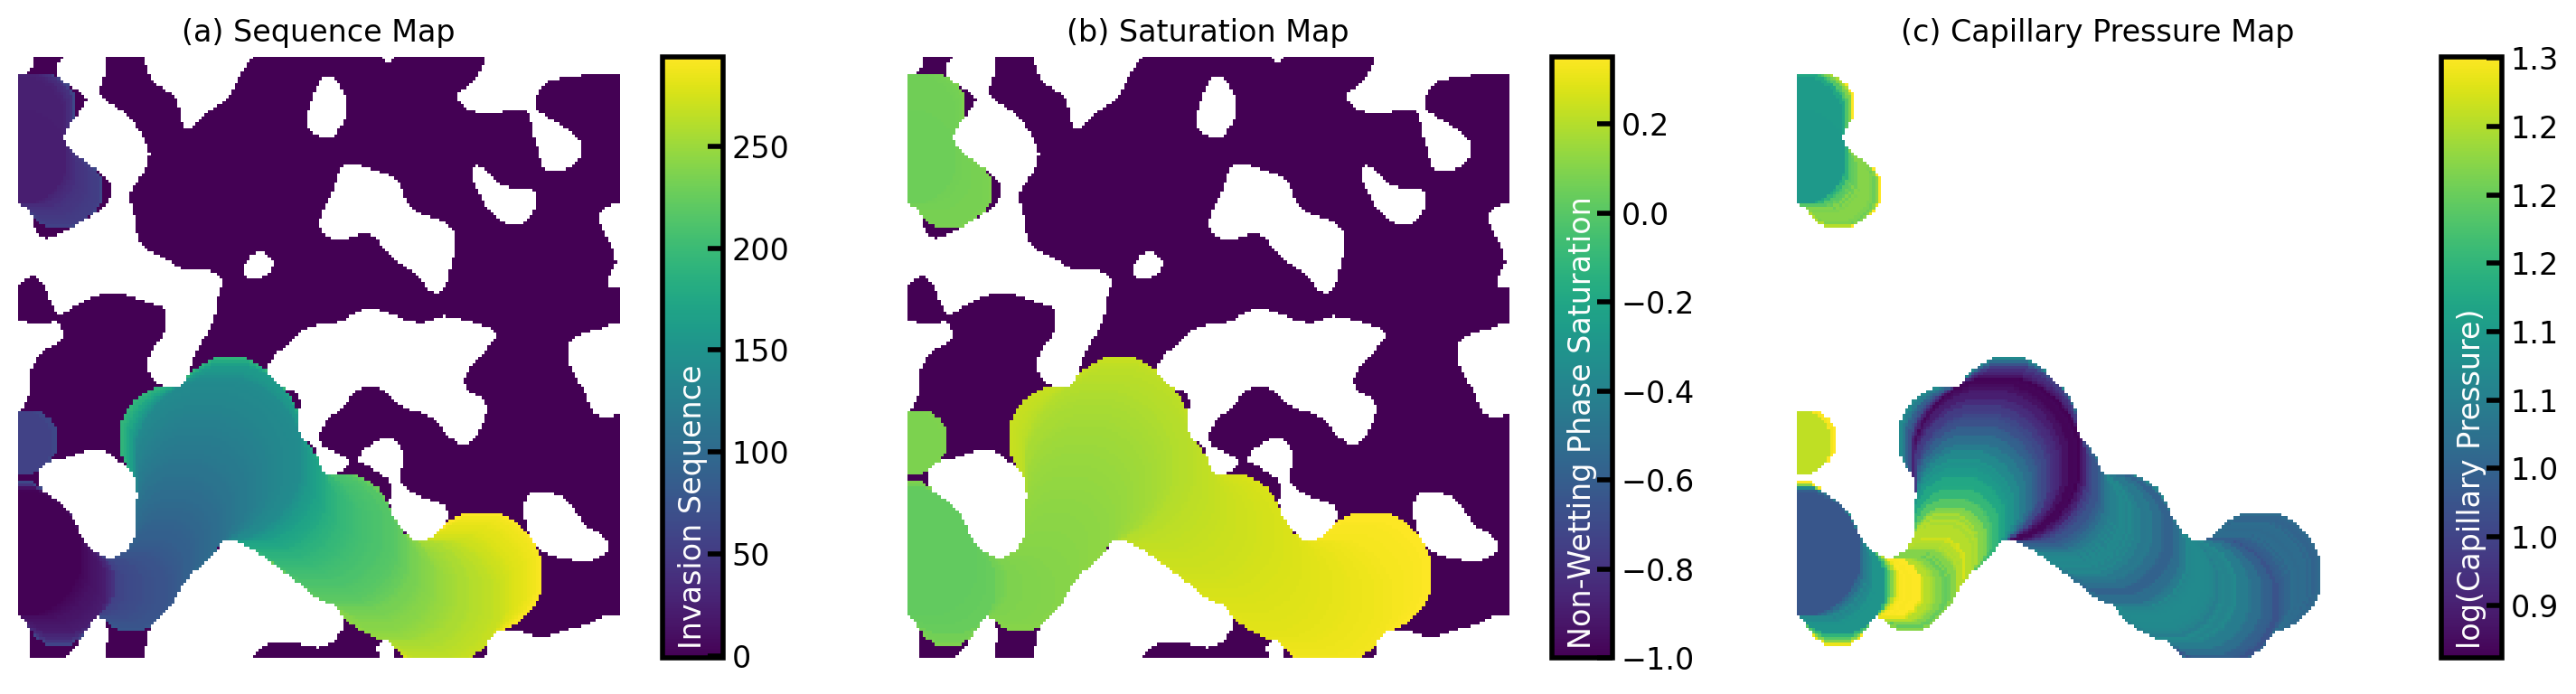

In [9]:
inv = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    maxiter=500,
)

plot_results(inv)

### `method`

The `method` argument allows the choice of the original "image-based invasion percolation" (`'ibip'`) algorithm which uses basic image analysis tools to find the next most easily invadable voxels on each loop, or it can use the new "queue-based" method (`'qbip'`) which uses a binary heap to implement a priority queue which makes the searching for the next invasion location much faster.  The `'ibip'` option is only included for legacy/academic reasons. Both methods give equivalent results while `'qbip'` is much faster.

In [10]:
inv1 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    method='qbip'
)
inv2 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    method='ibip'
)

diff = np.sum(inv1.im_seq != inv2.im_seq)
print(f"The number of pixels with a different value is {diff}")

The number of pixels with a different value is 0


## Other Arguments

### `dt`

Like many of the functions in PoreSpy, `injection` optionally accepts a distance transform. This is computed automatically if `dt` is not provided, but providing one can save a small amount of time if the distance transform has already been computed (which is often the case).

### `return_sizes` and `return_pressures`
These two flags indicate whether or not to compute the size map and capillary pressure maps.  Setting these to `False` can save some time if these results are not required.  `returns_pressures` is `True` by default, while `return_sizes` is `False`.